In [2]:
import os
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, interactive

import shutil
from pathlib import Path
import glob

import seaborn as sns
import pandas as pd
from metric import*
from config import *
from images import *
from reconstruct import *
from u_net_model import *

# Reconstruct
## load trained model

In [2]:
model=U_Net_Model(options['input_shape'],
                      options['out_channels'],
                      depth = options['depth'], 
                      initial_learning_rate = options['initial_learning_rate'],
                      deconvolution = options['deconvolution'])

model.build((None ,*options['input_shape']))
model.load_weights('./model_weights.hdf5')

input shape (None, 16, 16, 16, 4)


## order test data

In [3]:
path=options['test_data_path']
new_path=options['test_folder']+"{}_{}/"

patient_data=path+"{}/preprocessed/{}_{}_{}_pp.nii"

modalities=options['modalities']

test_csv_path=options["test_csv_path"]

In [8]:
_, dirs,_=next(os.walk(path))
for dir_ in dirs:
    flair_files = glob.glob(patient_data.format(dir_,dir_,'*',modalities[0]))
    for file in flair_files:
        study=file.split('/')[-1].split('_')[1]

        newpath = new_path.format(dir_,study)
        Path(newpath).mkdir(parents=True, exist_ok=True)
        # copy data and masks in new folders
        for m in modalities:
            data=patient_data.format(dir_,dir_,study,m)
            shutil.copy(data, newpath+f"{m}.nii")        

In [9]:
test_data=pd.DataFrame(columns=['root_path','patient_id','study',*modalities])
test_data = test_data.astype({"study": str})
root,dirs,_=next(os.walk(options['test_folder']))
for dir_ in dirs:
    patient_id=dir_.split('_')[0]
    study="_"+dir_.split('_')[1]
    root_path=root+dir_+"/"
    
    modalities_names=[]
    for modality in modalities:
        modalities_names.append(modality+".nii")
    df = pd.DataFrame([[root_path, patient_id,study,*modalities_names ]], columns=['root_path','patient_id','study',*modalities])
    test_data=test_data.append(df)
    
test_data.reset_index(inplace=True)
test_data.drop(columns=['index'],inplace=True)
test_data.to_csv(test_csv_path, index=False)

## reconstruct test data

In [ ]:
fold=0

test_df=pd.read_csv(options["test_csv_path"])

modalities= options['modalities']
step_size= options['step_size']
patch_size=options['patch_size']
dir_name = options['test_reconstruct_path']
os.makedirs(os.path.dirname(dir_name), exist_ok=True)


for i,row in test_df.iterrows():
    patient_id,study,root_path = row['patient_id'],row['study'],row['root_path']
    file_name = dir_name+ patient_id+study+"_predict"
    # load all modalities
    images = []
    for modality in modalities:
        img_path = root_path+modality+".nii"
        img = load_img(img_path)

        img = normalize_image(img,datatype=np.float32)
        images.append(img)
    images = np.moveaxis( np.stack(images),0,-1)
    
    predict_img(images,model, patch_size, step_size, file_name)
    print('reconstruct',patient_id+"_"+study)

# validation accuracy

In [59]:
lost=[]
accuracy_df=pd.DataFrame(columns=['patient_id','study','dice_coefficient','jaccard'])

fold=0
df=pd.read_csv(options["train_csv_path"])
train_df = df.loc[df['fold'] != fold].reset_index(drop=True)
val_df = df.loc[df['fold'] == fold].reset_index(drop=True)
file_name='{}{}.nii.gz'

for i,row in df.iterrows():
    patient_id,study,root_path = row['patient_id'],row['study'],row['root_path']
    # load target
    mask_path=root_path+"mask1.nii" 
    target = load_img(mask_path,np.float32)
    
    predict_path=options['train_reconstruct_path']+file_name.format(patient_id,study)
    if os.path.isfile(predict_path):
        predict=load_img(predict_path,np.float32)
        dice=dice_coefficient(np.expand_dims(np.expand_dims(target,axis=0),-1),np.expand_dims(np.expand_dims(predict,axis=0),axis=-1))

        df = pd.DataFrame([[patient_id,study,dice.numpy(), dice.numpy() ]], columns=['patient_id','study','dice_coefficient','jaccard'])
        accuracy_df=accuracy_df.append(df)
    else:
        lost.append(file_name.format(patient_id,study))
        
        
accuracy_df

,patient_id,study,dice_coefficient,jaccard
0,training01,_01,0.407864,0.407864
0,training01,_02,0.341790,0.341790
0,training01,_03,0.363168,0.363168
0,training01,_04,0.367765,0.367765
0,training02,_01,0.714906,0.714906
0,training02,_02,0.747589,0.747589
0,training02,_03,0.762445,0.762445
0,training02,_04,0.772853,0.772853
0,training03,_02,0.734951,0.734951
0,training03,_04,0.680688,0.680688


In [60]:
lost

['training03_01.nii.gz',
 'training03_03.nii.gz',
 'training03_05.nii.gz',
 'training04_03.nii.gz',
 'training05_02.nii.gz',
 'training05_03.nii.gz',
 'training05_04.nii.gz']

In [61]:
len(accuracy_df), len(lost), len(accuracy_df)+ len(lost)

(14, 7, 21)

<AxesSubplot:>

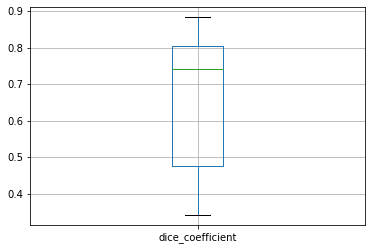

In [62]:
accuracy_df.boxplot(column='dice_coefficient')

In [63]:
val_df=accuracy_df.loc[:,['dice_coefficient','jaccard']]

In [56]:
#val_df=pd.concat([val_df,val_df], axis=1 )
val_df

,dice_coefficient,jaccard
0,0.407864,0.407864
0,0.341790,0.341790
0,0.363168,0.363168
0,0.367765,0.367765
0,0.714906,0.714906
0,0.747589,0.747589
0,0.772853,0.772853
0,0.734951,0.734951
0,0.680688,0.680688
0,0.850189,0.850189


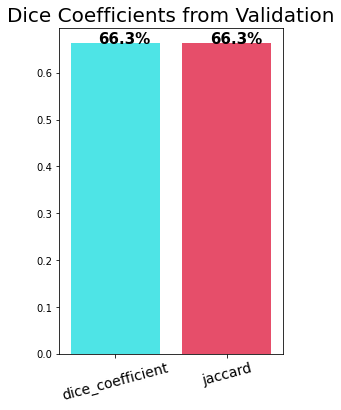

In [64]:
colors = ['#35FCFF', '#FF355A']
palette = sns.color_palette(colors, 2)

fig, ax = plt.subplots(figsize=(4, 6));
sns.barplot(x=val_df.mean().index, y=val_df.mean(), palette=palette, ax=ax);
ax.set_xticklabels(val_df.columns, fontsize=14, rotation=15);
ax.set_title("Dice Coefficients from Validation", fontsize=20)

for idx, p in enumerate(ax.patches):
        percentage = '{:.1f}%'.format(100 * val_df.mean().values[idx])
        x = p.get_x() + p.get_width() / 2 - 0.15
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), fontsize=15, fontweight="bold")

fig.savefig("result1.png", format="png",  pad_inches=0.2, transparent=False, bbox_inches='tight')
fig.savefig("result1.svg", format="svg",  pad_inches=0.2, transparent=False, bbox_inches='tight')

## reconstruct train data

In [8]:
fold=0

df=pd.read_csv(options["train_csv_path"])
train_df = df.loc[df['fold'] != fold].reset_index(drop=True)
val_df = df.loc[df['fold'] == fold].reset_index(drop=True)

modalities= options['modalities']
step_size= options['step_size']
patch_size=options['patch_size']
dir_name = options['reconstruct_path']
os.makedirs(os.path.dirname(dir_name), exist_ok=True)


for i,row in val_df.iterrows():
    patient_id,study,root_path = row['patient_id'],row['study'],row['root_path']
    # load all modalities
    images = []
    for modality in modalities:
        img_path = root_path+modality+".nii"
        img = load_img(img_path)

        img = normalize_image(img,datatype=np.float32)
        #padding=[(0,o_s%(p_s+s_s)) for o_s, p_s, s_s in zip(orig_shape, patch_size, step_size)]
        
        #img=np.pad(img, padding, 'constant')
        #print('padding',padding,img.shape)
        #print(img.shape)
        images.append(img)
    
    mask_path=root_path+"mask1.nii"
    img = np.moveaxis( np.stack(images),0,-1)
    
    mask = load_img(mask_path)
    
    #mask=np.pad(mask, padding, 'constant')
    shape=mask.shape

    image_real  = Reconstruct(i, shape, patch_size, False)
    predict  = Reconstruct(i, shape, patch_size, False)
    truth = Reconstruct(i, shape, patch_size, False)
    x=0
    while(x+patch_size[0] <= shape[0]):
        y=0
        while(y+patch_size[1]<= shape[1]):
            z=0
            while(z+patch_size[2] <= shape[2]):
                #print(z, (shape[2]-(shape[2]%patch_size[2])))
                patch_start=(x,y,z)
                patch_end=tuple([p+s for p,s in zip(patch_start,patch_size)])
                #print('start',patch_start,'end',patch_end)
                patch_img=img[patch_start[0]:patch_end[0], patch_start[1]:patch_end[1], patch_start[2]:patch_end[2]]
                
                patch_mask=mask[patch_start[0]:patch_end[0], patch_start[1]:patch_end[1], patch_start[2]:patch_end[2]]
                #print('start',patch_start,'end',patch_end,'patch',patch_img.shape)
                #print(patch_img.shape,patch_mask.shape,result.shape,patch_index_row)
                
                predict_img=model.predict(np.expand_dims(patch_img,axis=0))               
                
                predict.add(np.squeeze(np.squeeze(predict_img, axis=0),axis=-1), patch_start)             
                image_real.add(patch_img[:,:,:,0], patch_start)
                truth.add(patch_mask, patch_start)
        
                z+=step_size[2]
                
            y+=step_size[1]
        x+=step_size[0]
    
    file_name = dir_name+ patient_id+study
    image_real.store(file_name + "_image_real")
    truth.store(file_name + "_target")
    print('reconstruct',patient_id+"_"+study)

Exception ignored in: <function ConcreteFunctionGarbageCollector.__del__ at 0x7f239d139f80>
Traceback (most recent call last):
  File "/home/marwa/Medical_Analysis/Code/work_start/lib/python3.7/site-packages/tensorflow/python/eager/function.py", line 3940, in __del__
    def __del__(self):
KeyboardInterrupt: 


KeyboardInterrupt: 

In [11]:
val_df.root_path[0]

'/media/marwa/F2F25460F2542ADD/MedicalAnalysis/DataSets/ISBI/train/training01_01/'

In [32]:
n='03_02'
data_path=options['train_folder']
pp1=data_path+'training'+n+'/mask1.nii'
pp2=data_path+'training'+n+'/mask2.nii'
data_p='/media/marwa/F2F25460F2542ADD/MedicalAnalysis/DataSets/ISBI/reconstruct/'
p=data_p+'training05_01.nii.gz'
target1=load_img(pp1,np.float32)
target2=load_img(pp2,np.float32)
predict=load_img(p,np.float32)
show3D_images([target1,target2, predict])

interactive(children=(IntSlider(value=90, description='id', max=180), Output()), _dom_classes=('widget-interac…

In [31]:
dice_coefficient(np.expand_dims(np.expand_dims(target1,axis=0),-1),np.expand_dims(np.expand_dims(predict,axis=0),axis=-1))

<tf.Tensor: shape=(), dtype=float32, numpy=0.85302025>

In [27]:
import tensorflow as tf
tf.keras.metrics.MeanSquaredError(target,predict)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()